#### ***Import Sagemaker Library***

In [1]:
import sagemaker

In [2]:
sess = sagemaker.Session()

#### ***Import the Execute Role***

In [3]:
from sagemaker import get_execution_role

In [4]:
role = get_execution_role()

In [5]:
print(role)

arn:aws:iam::685819979248:role/service-role/AmazonSageMaker-ExecutionRole-20200229T161385


#### ***Downloading file from Git***

!wget https://github.com/Rajesh-ML-Engg/Autism_Spectrum_Disorder/blob/master/Autism_Child_data_in_excel.xlsx

#### ***Setup connectivity with S3***

In [6]:
import boto3

In [7]:
bucket = sess.default_bucket()
file_name = 'Autism_Child_data_in_excel.xlsx'
s3_file = 's3://{}/{}'.format(bucket,file_name)

In [8]:
print(s3_file)

s3://sagemaker-us-east-1-685819979248/Autism_Child_data_in_excel.xlsx


#### ***Import Data Science Libraries***

In [9]:
!pip install category_encoders

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import seaborn as sns
import os, re
import category_encoders as ce

%matplotlib inline

#### ***Setting the display parameters***

In [11]:
np.floor(np.log2(1000))+1

10.0

In [12]:
pd.set_option('display.max_columns',35)

In [13]:
pd.set_option('display.max_rows',200)

#### ***DataFrame from S3 File***

In [14]:
ASD_Child = pd.read_excel(s3_file,sheet_name='Autism_Child')

In [15]:
ASD_Adolescent = pd.read_excel(s3_file,sheet_name='Autism_Adolscent')

In [16]:
ASD_Adult = pd.read_excel(s3_file,sheet_name='Autism_Adult')

#### ***Merging DataFrames***

In [17]:
ASD_df = pd.concat([ASD_Child,ASD_Adolescent,ASD_Adult],axis=0)

#### ***Initial Data Analysis(IDA)***

In [18]:
ASD_df.head()

,age,gender,ethnicity,jundice,autism,relation,contry_of_res,used_app_before,age_desc,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,result,Class
0,6,m,Others,no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO
1,6,m,'Middle Eastern ',no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO
2,6,m,?,no,no,?,Jordan,yes,'4-11 years',1,1,0,0,0,1,1,1,0,0,5,NO
3,5,f,?,yes,no,?,Jordan,no,'4-11 years',0,1,0,0,1,1,0,0,0,1,4,NO
4,5,m,Others,yes,no,Parent,'United States',no,'4-11 years',1,1,1,1,1,1,1,1,1,1,10,YES


In [19]:
ASD_df.columns

Index(['age', 'gender', 'ethnicity', 'jundice', 'autism', 'relation',
       'contry_of_res', 'used_app_before', 'age_desc', 'A1_Score', 'A2_Score',
       'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score',
       'A9_Score', 'A10_Score', 'result', 'Class'],
      dtype='object')

In [20]:
ASD_df.columns = ['age', 'gender', 'ethnicity', 'jaundice', 'parents_with_autism', 'whos_taking_test','country_of_res', 'used_app_before',
                  'age_desc', 'Q1_Score', 'Q2_Score', 'Q3_Score', 'Q4_Score', 'Q5_Score', 'Q6_Score','Q7_Score', 'Q8_Score','Q9_Score',
                  'Q10_Score', 'screening_score', 'ASD_Label']

#### ***IDA - Step:1 - Data Type Handling***

In [21]:
ASD_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 703
Data columns (total 21 columns):
age                    1100 non-null object
gender                 1100 non-null object
ethnicity              1100 non-null object
jaundice               1100 non-null object
parents_with_autism    1100 non-null object
whos_taking_test       1100 non-null object
country_of_res         1100 non-null object
used_app_before        1100 non-null object
age_desc               1100 non-null object
Q1_Score               1100 non-null int64
Q2_Score               1100 non-null int64
Q3_Score               1100 non-null int64
Q4_Score               1100 non-null int64
Q5_Score               1100 non-null int64
Q6_Score               1100 non-null int64
Q7_Score               1100 non-null int64
Q8_Score               1100 non-null int64
Q9_Score               1100 non-null int64
Q10_Score              1100 non-null int64
screening_score        1100 non-null int64
ASD_Label              11

##### Age, Gender, Jaundice, Parents_with_autism, Used_app_before and ASD_Label to be converted to INT datatype. 
##### Out of these Gender, Jaundice, Parents_with_autism, Used_app_before and ASD_Label will be converted as Binary or Nominal categorical variables.

##### In the above output of Info(), you will find the Index is from 0 to 703, however, the records are 1100. So, we need to reset the index of the DataFrame.

In [22]:
ASD_df.reset_index(drop=True,inplace=True)

In [23]:
ASD_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
age                    1100 non-null object
gender                 1100 non-null object
ethnicity              1100 non-null object
jaundice               1100 non-null object
parents_with_autism    1100 non-null object
whos_taking_test       1100 non-null object
country_of_res         1100 non-null object
used_app_before        1100 non-null object
age_desc               1100 non-null object
Q1_Score               1100 non-null int64
Q2_Score               1100 non-null int64
Q3_Score               1100 non-null int64
Q4_Score               1100 non-null int64
Q5_Score               1100 non-null int64
Q6_Score               1100 non-null int64
Q7_Score               1100 non-null int64
Q8_Score               1100 non-null int64
Q9_Score               1100 non-null int64
Q10_Score              1100 non-null int64
screening_score        1100 non-null int64
ASD_Label              1

#### ***Fixing AGE variable***

In [24]:
ASD_df['age'].isin(['?']).sum()

6

##### AGE variable contains 6 records with MISSING values. For now, I'll replace these value with None and later on build a Regression Model to predict these values.

In [25]:
ASD_df['age'] = ASD_df['age'].apply(lambda val : np.NaN if val == '?' else np.int(val))

In [26]:
ASD_df['age'].isin(['?']).sum()

0

In [27]:
ASD_df['age'].isna().sum()

6

In [28]:
pd.DataFrame(ASD_df['age'].describe())

,age
count,1094.000000
mean,22.073126
std,16.879373
min,4.000000
25%,11.000000
50%,21.000000
75%,30.000000
max,383.000000


##### Here, we found that Age of one of the patients is 383. And, it seems to be a typing error. So, we will mark Age variable as None for this record as well. 

##### And, later on we will predict the value for this records as well by using Regression Model.

##### ***Finding the AGE values for possible quantiles***

In [29]:
quantiles = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.97,0.98,0.99,0.999,0.9999]

In [30]:
ASD_df['age'].quantile(quantiles)

0.1000      5.0000
0.1500      6.0000
0.2000      8.0000
0.2500     11.0000
0.3000     13.0000
0.3500     16.0000
0.4000     18.0000
0.4500     20.0000
0.5000     21.0000
0.5500     22.0000
0.6000     24.0000
0.6500     26.0000
0.7000     28.0000
0.7500     30.0000
0.8000     32.0000
0.8500     35.0500
0.9000     40.0000
0.9500     46.0000
0.9700     50.0000
0.9800     53.0000
0.9900     55.0000
0.9990     63.7210
0.9999    348.1333
Name: age, dtype: float64

In [31]:
ASD_df['age'].sort_values(ascending=False).head()

448    383.0
403     64.0
827     61.0
891     61.0
599     60.0
Name: age, dtype: float64

In [32]:
ASD_df['age'] = ASD_df['age'].apply(lambda val : np.NaN if val > 100 else val)

In [33]:
ASD_df['age'].sort_values(ascending=False).head()

403    64.0
891    61.0
827    61.0
599    60.0
844    59.0
Name: age, dtype: float64

In [34]:
ASD_df['age'].isna().sum()

7

In [35]:
ASD_df['age'].quantile(quantiles)

0.1000     5.0000
0.1500     6.0000
0.2000     8.0000
0.2500    11.0000
0.3000    13.0000
0.3500    16.0000
0.4000    18.0000
0.4500    20.0000
0.5000    21.0000
0.5500    22.0000
0.6000    24.0000
0.6500    26.0000
0.7000    27.4000
0.7500    30.0000
0.8000    32.0000
0.8500    35.0000
0.9000    40.0000
0.9500    45.4000
0.9700    50.0000
0.9800    53.0000
0.9900    55.0000
0.9990    61.0000
0.9999    63.6724
Name: age, dtype: float64

#### ***Fixing GENDER variable***

In [36]:
ASD_df['gender'].value_counts()

m    625
f    475
Name: gender, dtype: int64

##### In GENDER variable, we have two Categories M(Male) and F(Female). Thus, it is a Nominal feature and we will encode M as 1 and F as 0.

In [37]:
BE = ce.BinaryEncoder()

In [38]:
gender_df = BE.fit_transform(ASD_df['gender'])

In [39]:
gender_df.head()

,gender_0,gender_1
0,0,1
1,0,1
2,0,1
3,1,0
4,0,1


In [40]:
gender_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 2 columns):
gender_0    1100 non-null int64
gender_1    1100 non-null int64
dtypes: int64(2)
memory usage: 17.3 KB


In [41]:
gender_df['gender_0'].value_counts()

0    625
1    475
Name: gender_0, dtype: int64

In [42]:
gender_df['gender_1'].value_counts()

1    625
0    475
Name: gender_1, dtype: int64

In [43]:
ASD_df = pd.concat([ASD_df,gender_df],axis=1)

In [44]:
ASD_df.head()

,age,gender,ethnicity,jaundice,parents_with_autism,whos_taking_test,country_of_res,used_app_before,age_desc,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,screening_score,ASD_Label,gender_0,gender_1
0,6.0,m,Others,no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1
1,6.0,m,'Middle Eastern ',no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1
2,6.0,m,?,no,no,?,Jordan,yes,'4-11 years',1,1,0,0,0,1,1,1,0,0,5,NO,0,1
3,5.0,f,?,yes,no,?,Jordan,no,'4-11 years',0,1,0,0,1,1,0,0,0,1,4,NO,1,0
4,5.0,m,Others,yes,no,Parent,'United States',no,'4-11 years',1,1,1,1,1,1,1,1,1,1,10,YES,0,1


#### ***Finding Co-relations b/w Gender variables***

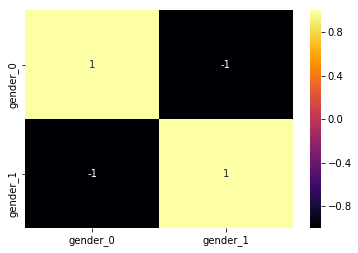

In [45]:
sns.heatmap(gender_df.corr(),cmap='inferno',annot=True, cbar=True)

#### ***Fixing JAUNDICE variable***

In [46]:
ASD_df['jaundice'].value_counts()

no     935
yes    165
Name: jaundice, dtype: int64

In [47]:
from sklearn.preprocessing import LabelBinarizer

In [48]:
lb = LabelBinarizer()

In [49]:
jaundice_df = pd.DataFrame(lb.fit_transform(ASD_df['jaundice']),columns=['fix_jaundice'])

In [50]:
jaundice_df['fix_jaundice'].value_counts()

0    935
1    165
Name: fix_jaundice, dtype: int64

##### JAUNDICE is a Binary Nominal variable with NO that is represented as 0 and YES as 1.

In [51]:
ASD_df = pd.concat([ASD_df,jaundice_df],axis=1)

In [52]:
ASD_df.head()

,age,gender,ethnicity,jaundice,parents_with_autism,whos_taking_test,country_of_res,used_app_before,age_desc,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,screening_score,ASD_Label,gender_0,gender_1,fix_jaundice
0,6.0,m,Others,no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1,0
1,6.0,m,'Middle Eastern ',no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1,0
2,6.0,m,?,no,no,?,Jordan,yes,'4-11 years',1,1,0,0,0,1,1,1,0,0,5,NO,0,1,0
3,5.0,f,?,yes,no,?,Jordan,no,'4-11 years',0,1,0,0,1,1,0,0,0,1,4,NO,1,0,1
4,5.0,m,Others,yes,no,Parent,'United States',no,'4-11 years',1,1,1,1,1,1,1,1,1,1,10,YES,0,1,1


#### ***Fixing Parents_with_Autism***

In [53]:
ASD_df['parents_with_autism'].value_counts()

no     946
yes    154
Name: parents_with_autism, dtype: int64

In [54]:
parents_with_autism_df = pd.DataFrame(lb.fit_transform(ASD_df['parents_with_autism']),columns=['fix_parents_with_autism'])

In [55]:
ASD_df = pd.concat([ASD_df,parents_with_autism_df],axis=1)

##### Parents_with_autism is a Binary Nominal Variable where No is represented as 0 and Yes as 1.

In [56]:
ASD_df.head(7)

,age,gender,ethnicity,jaundice,parents_with_autism,whos_taking_test,country_of_res,used_app_before,age_desc,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,screening_score,ASD_Label,gender_0,gender_1,fix_jaundice,fix_parents_with_autism
0,6.0,m,Others,no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1,0,0
1,6.0,m,'Middle Eastern ',no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1,0,0
2,6.0,m,?,no,no,?,Jordan,yes,'4-11 years',1,1,0,0,0,1,1,1,0,0,5,NO,0,1,0,0
3,5.0,f,?,yes,no,?,Jordan,no,'4-11 years',0,1,0,0,1,1,0,0,0,1,4,NO,1,0,1,0
4,5.0,m,Others,yes,no,Parent,'United States',no,'4-11 years',1,1,1,1,1,1,1,1,1,1,10,YES,0,1,1,0
5,4.0,m,?,no,yes,?,Egypt,no,'4-11 years',0,0,1,0,1,1,0,1,0,1,5,NO,0,1,0,1
6,5.0,m,White-European,no,no,Parent,'United Kingdom',no,'4-11 years',1,0,1,1,1,1,0,1,0,1,7,YES,0,1,0,0


#### ***Fixing Used_app_before***

In [57]:
ASD_df['used_app_before'].value_counts()

no     1073
yes      27
Name: used_app_before, dtype: int64

In [58]:
used_app_before_df = pd.DataFrame(lb.fit_transform(ASD_df['used_app_before']),columns=['fix_used_app_before'])

In [59]:
ASD_df = pd.concat([ASD_df,used_app_before_df],axis=1)

##### Used_app_before is a Binary Nominal Variable where No is represented as 0 and Yes as 1.

In [60]:
ASD_df.head(7)

,age,gender,ethnicity,jaundice,parents_with_autism,whos_taking_test,country_of_res,used_app_before,age_desc,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,screening_score,ASD_Label,gender_0,gender_1,fix_jaundice,fix_parents_with_autism,fix_used_app_before
0,6.0,m,Others,no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1,0,0,0
1,6.0,m,'Middle Eastern ',no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1,0,0,0
2,6.0,m,?,no,no,?,Jordan,yes,'4-11 years',1,1,0,0,0,1,1,1,0,0,5,NO,0,1,0,0,1
3,5.0,f,?,yes,no,?,Jordan,no,'4-11 years',0,1,0,0,1,1,0,0,0,1,4,NO,1,0,1,0,0
4,5.0,m,Others,yes,no,Parent,'United States',no,'4-11 years',1,1,1,1,1,1,1,1,1,1,10,YES,0,1,1,0,0
5,4.0,m,?,no,yes,?,Egypt,no,'4-11 years',0,0,1,0,1,1,0,1,0,1,5,NO,0,1,0,1,0
6,5.0,m,White-European,no,no,Parent,'United Kingdom',no,'4-11 years',1,0,1,1,1,1,0,1,0,1,7,YES,0,1,0,0,0


#### ***Fixing Age_desc***

In [61]:
ASD_df['age_desc'].value_counts()

'18 and more'    704
'4-11 years'     292
'12-16 years'     97
'12-15 years'      7
Name: age_desc, dtype: int64

##### Age_Desc is an Ordinal Categorical Variable. And, below are the points that we need to clarify related to this variable:
    Q1. Why we have '12-15 years' category when we have '12-16 years' category?
        - Is it a typing error?
        
    Q2. Why we don't have any AGE category for 17 year old patients?
        - Is this a typing error?
        - We don't have any patient with ages as 17 years?

In [62]:
ASD_df[ASD_df['age_desc'] == "'4-11 years'"]['age'].value_counts()

4.0     92
5.0     45
6.0     39
7.0     27
11.0    26
8.0     21
9.0     20
10.0    18
Name: age, dtype: int64

In [63]:
ASD_df[ASD_df['age_desc'] == "'12-15 years'"]['age'].value_counts()

16.0    3
15.0    3
12.0    1
Name: age, dtype: int64

In [64]:
ASD_df[ASD_df['age_desc'] == "'12-16 years'"]['age'].value_counts()

16.0    28
12.0    24
13.0    16
15.0    15
14.0    14
Name: age, dtype: int64

In [65]:
ASD_df[ASD_df['age_desc'] == "'18 and more'"]['age'].value_counts().sort_index()

17.0    18
18.0    31
19.0    35
20.0    46
21.0    49
22.0    37
23.0    37
24.0    34
25.0    27
26.0    28
27.0    31
28.0    24
29.0    27
30.0    30
31.0    21
32.0    18
33.0    16
34.0    12
35.0    17
36.0    13
37.0    17
38.0    12
39.0     7
40.0    16
41.0     3
42.0    15
43.0    11
44.0    10
45.0     4
46.0     6
47.0     8
48.0     4
49.0     3
50.0     5
51.0     1
52.0     5
53.0     6
54.0     2
55.0     6
56.0     2
58.0     2
59.0     1
60.0     1
61.0     2
64.0     1
Name: age, dtype: int64

In [66]:
ASD_df['age_desc'] = ASD_df['age_desc'].apply(lambda val: "'12-16 years'" if val == "'12-15 years'" else 
                                              "'17 and more'" if val == "'18 and more'" else val)

In [67]:
ASD_df['age_desc'].value_counts()

'17 and more'    704
'4-11 years'     292
'12-16 years'    104
Name: age_desc, dtype: int64

In [68]:
OE = ce.OrdinalEncoder()

In [69]:
age_desc_df = OE.fit_transform(ASD_df['age_desc'])

In [70]:
age_desc_df.columns = ['fix_age_desc']

In [71]:
age_desc_df.head()

,fix_age_desc
0,1
1,1
2,1
3,1
4,1


In [72]:
age_desc_df.iloc[:,0].value_counts()

3    704
1    292
2    104
Name: fix_age_desc, dtype: int64

In [73]:
OE.get_params

<bound method BaseEstimator.get_params of OrdinalEncoder(cols=['age_desc'], drop_invariant=False,
        handle_missing='value', handle_unknown='value',
        mapping=[{'col': 'age_desc', 'mapping': '4-11 years'     1
'12-16 years'    2
'17 and more'    3
NaN             -2
dtype: int64, 'data_type': dtype('O')}],
        return_df=True, verbose=0)>

In [74]:
ASD_df = pd.concat([ASD_df,age_desc_df],axis=1)

In [75]:
ASD_df.head(7)

,age,gender,ethnicity,jaundice,parents_with_autism,whos_taking_test,country_of_res,used_app_before,age_desc,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,screening_score,ASD_Label,gender_0,gender_1,fix_jaundice,fix_parents_with_autism,fix_used_app_before,fix_age_desc
0,6.0,m,Others,no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1,0,0,0,1
1,6.0,m,'Middle Eastern ',no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1,0,0,0,1
2,6.0,m,?,no,no,?,Jordan,yes,'4-11 years',1,1,0,0,0,1,1,1,0,0,5,NO,0,1,0,0,1,1
3,5.0,f,?,yes,no,?,Jordan,no,'4-11 years',0,1,0,0,1,1,0,0,0,1,4,NO,1,0,1,0,0,1
4,5.0,m,Others,yes,no,Parent,'United States',no,'4-11 years',1,1,1,1,1,1,1,1,1,1,10,YES,0,1,1,0,0,1
5,4.0,m,?,no,yes,?,Egypt,no,'4-11 years',0,0,1,0,1,1,0,1,0,1,5,NO,0,1,0,1,0,1
6,5.0,m,White-European,no,no,Parent,'United Kingdom',no,'4-11 years',1,0,1,1,1,1,0,1,0,1,7,YES,0,1,0,0,0,1


#### ***Fixing ASD_Label***

In [76]:
ASD_df['ASD_Label'].value_counts()

NO     707
YES    393
Name: ASD_Label, dtype: int64

In [77]:
ASD_label_df = pd.DataFrame(lb.fit_transform(ASD_df['ASD_Label']),columns=['fix_ASD_Label'])

In [78]:
ASD_label_df.iloc[:,0].value_counts()

0    707
1    393
Name: fix_ASD_Label, dtype: int64

##### ASD_Label is a Binary Nominal Variable where 0 and 1 denotes No and Yes respectively.

In [79]:
ASD_df = pd.concat([ASD_df,ASD_label_df],axis=1)

In [80]:
ASD_df.head(7)

,age,gender,ethnicity,jaundice,parents_with_autism,whos_taking_test,country_of_res,used_app_before,age_desc,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,screening_score,ASD_Label,gender_0,gender_1,fix_jaundice,fix_parents_with_autism,fix_used_app_before,fix_age_desc,fix_ASD_Label
0,6.0,m,Others,no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1,0,0,0,1,0
1,6.0,m,'Middle Eastern ',no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1,0,0,0,1,0
2,6.0,m,?,no,no,?,Jordan,yes,'4-11 years',1,1,0,0,0,1,1,1,0,0,5,NO,0,1,0,0,1,1,0
3,5.0,f,?,yes,no,?,Jordan,no,'4-11 years',0,1,0,0,1,1,0,0,0,1,4,NO,1,0,1,0,0,1,0
4,5.0,m,Others,yes,no,Parent,'United States',no,'4-11 years',1,1,1,1,1,1,1,1,1,1,10,YES,0,1,1,0,0,1,1
5,4.0,m,?,no,yes,?,Egypt,no,'4-11 years',0,0,1,0,1,1,0,1,0,1,5,NO,0,1,0,1,0,1,0
6,5.0,m,White-European,no,no,Parent,'United Kingdom',no,'4-11 years',1,0,1,1,1,1,0,1,0,1,7,YES,0,1,0,0,0,1,1


#### ***IDA - Step:2 - Finding and fixing Missing values***

In [81]:
ASD_df.isin(['?',np.NaN]).sum()

age                          7
gender                       0
ethnicity                  144
jaundice                     0
parents_with_autism          0
whos_taking_test           144
country_of_res               0
used_app_before              0
age_desc                     0
Q1_Score                     0
Q2_Score                     0
Q3_Score                     0
Q4_Score                     0
Q5_Score                     0
Q6_Score                     0
Q7_Score                     0
Q8_Score                     0
Q9_Score                     0
Q10_Score                    0
screening_score              0
ASD_Label                    0
gender_0                     0
gender_1                     0
fix_jaundice                 0
fix_parents_with_autism      0
fix_used_app_before          0
fix_age_desc                 0
fix_ASD_Label                0
dtype: int64

##### AGE contains the NULL values. ETHNICITY and WHOS_TAKING_TEST comprises Missing values.

#### ***Standardizing COUNTRY_OF_RES***

In [82]:
ASD_df.head()

,age,gender,ethnicity,jaundice,parents_with_autism,whos_taking_test,country_of_res,used_app_before,age_desc,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,screening_score,ASD_Label,gender_0,gender_1,fix_jaundice,fix_parents_with_autism,fix_used_app_before,fix_age_desc,fix_ASD_Label
0,6.0,m,Others,no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1,0,0,0,1,0
1,6.0,m,'Middle Eastern ',no,no,Parent,Jordan,no,'4-11 years',1,1,0,0,1,1,0,1,0,0,5,NO,0,1,0,0,0,1,0
2,6.0,m,?,no,no,?,Jordan,yes,'4-11 years',1,1,0,0,0,1,1,1,0,0,5,NO,0,1,0,0,1,1,0
3,5.0,f,?,yes,no,?,Jordan,no,'4-11 years',0,1,0,0,1,1,0,0,0,1,4,NO,1,0,1,0,0,1,0
4,5.0,m,Others,yes,no,Parent,'United States',no,'4-11 years',1,1,1,1,1,1,1,1,1,1,10,YES,0,1,1,0,0,1,1


In [83]:
ASD_df['country_of_res'].value_counts()

'United States'            167
'United Kingdom'           155
India                      130
'New Zealand'               95
'United Arab Emirates'      90
Jordan                      68
Australia                   52
Canada                      25
Afghanistan                 17
Argentina                   14
'Sri Lanka'                 14
Egypt                       14
Netherlands                 13
France                      12
Brazil                      12
Austria                     11
Mexico                      10
Bangladesh                  10
Russia                      10
Philippines                  8
'Saudi Arabia'               8
Iran                         7
Malaysia                     7
Italy                        7
Ireland                      7
Pakistan                     7
'Viet Nam'                   6
Germany                      5
'South Africa'               5
Belgium                      5
Armenia                      5
Iraq                         4
Romania 

In [84]:
def remove_punctuations(val):
    return val.replace("'",'')

In [85]:
ASD_df['country_of_res'] = ASD_df['country_of_res'].apply(lambda val: str(''.join(list(map(remove_punctuations,val)))).capitalize())

In [86]:
ASD_df['country_of_res'].value_counts()

United states            167
United kingdom           155
India                    130
New zealand               95
United arab emirates      90
Jordan                    68
Australia                 52
Canada                    25
Afghanistan               17
Argentina                 14
Sri lanka                 14
Egypt                     14
Netherlands               13
France                    12
Brazil                    12
Austria                   11
Russia                    10
Bangladesh                10
Mexico                    10
Saudi arabia               8
Philippines                8
Italy                      7
Malaysia                   7
Iran                       7
Ireland                    7
Pakistan                   7
Viet nam                   6
Belgium                    5
Armenia                    5
South africa               5
Germany                    5
Romania                    4
Americansamoa              4
Indonesia                  4
Iraq          

#### ***Fixing WHOS_TAKING_TEST***

In [87]:
ASD_df['whos_taking_test'].value_counts()

Self                          571
Parent                        300
?                             144
Relative                       53
'Health care professional'     23
Others                          8
self                            1
Name: whos_taking_test, dtype: int64

##### ***Standardizing WHOS_TAKING_TEST***

In [88]:
ASD_df['whos_taking_test'] = ASD_df['whos_taking_test'].apply(lambda val: str(val.replace("'",'')).capitalize())

In [89]:
pd.DataFrame(ASD_df.groupby(['age_desc','whos_taking_test']).count()['age']).sort_values(by=['age_desc','age'],ascending=False)

age
age_desc      whos_taking_test             
'4-11 years'  Parent                    213
              ?                          40
              Relative                   17
              Health care professional   13
              Self                        5
'17 and more' Self                      521
              ?                          93
              Parent                     50
              Relative                   28
              Others                      5
              Health care professional    4
'12-16 years' Self                       45
              Parent                     36
              Relative                    8
              ?                           6
              Health care professional    6
              Others                      3

In [90]:
def fix_whos_taking_test(df_name):
    """
    #Description#
        This function is fixing the missing values in Whos_taking_test variable.
    #Input#
        df_name: It accepts the DataFrame containg all the records.
    #Return#
        Generates the new DataFrame with fixed missing values.
    """
    # Finding the count of every value in Whos_taking_test for every Age_Desc in a descending order
    age_desc_vals = pd.DataFrame(df_name.groupby(['age_desc','whos_taking_test']).count()['age']).sort_values(by=['age_desc','age'],ascending=False)
    age_desc_vals.reset_index(inplace=True)
    # Creating a DataFrame having Maximum count of Whos_taking_test category for each Age_desc
    max_whos_taking_test = pd.DataFrame(age_desc_vals.groupby(['age_desc'])['age'].max())
    max_whos_taking_test.reset_index(inplace=True)
    # Finding the MAX occurences of categories in Whos_taking_test w.r.t all Age_Desc
    whos_taking_test_per_age_desc = pd.merge(max_whos_taking_test,age_desc_vals,on='age')
    whos_taking_test_per_age_desc.drop(['age_desc_y'],inplace=True,axis=1)
    whos_taking_test_per_age_desc.columns = ['age_desc','number_of_times','person_took_test']
    # Segregating Not Nulls and Nulls records of Whos_taking_test 
    Not_null_whos_taking_test = df_name[~df_name['whos_taking_test'].isin(['?'])]
    Null_whos_taking_test = df_name[df_name['whos_taking_test'].isin(['?'])]
    # Fixing the Nulls of Whos_taking_test
    Null_fix_whos_taking_test = pd.merge(Null_whos_taking_test,whos_taking_test_per_age_desc,on='age_desc')
    Null_fix_whos_taking_test.drop(['number_of_times','whos_taking_test'],axis=1,inplace=True)
    # Renaming the last column
    cols = Null_fix_whos_taking_test.columns[0:-1]
    cols = cols[::-1]
    cols = cols.insert(0,'whos_taking_test')
    cols = cols[::-1]
    Null_fix_whos_taking_test.columns = cols
    # Create the fixed DataFrame
    Not_null_whos_taking_test.reset_index(drop=True,inplace=True)
    fix_df = pd.concat([Not_null_whos_taking_test,Null_fix_whos_taking_test],axis=0,sort=True)
    fix_df.reset_index(drop=True,inplace=True)
    return fix_df

In [91]:
%%time
ASD_df1 = fix_whos_taking_test(ASD_df)

CPU times: user 27.8 ms, sys: 0 ns, total: 27.8 ms
Wall time: 28.1 ms


In [92]:
%%timeit -n 100
ASD_df1 = fix_whos_taking_test(ASD_df)

26.5 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [93]:
(25.2*10000)/(1000*60) ## Number of records 1100*10000 = 1,10,00,000 (11 million or 110 Lacs)

4.2

\begin{align*}
10^{-3} milliseconds \\
10^{-6} microseconds \\
10^{-9} nanoseconds
\end{align*}

In [94]:
ASD_df1.head()

,ASD_Label,Q10_Score,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,age,age_desc,country_of_res,ethnicity,fix_ASD_Label,fix_age_desc,fix_jaundice,fix_parents_with_autism,fix_used_app_before,gender,gender_0,gender_1,jaundice,parents_with_autism,screening_score,used_app_before,whos_taking_test
0,NO,0,1,1,0,0,1,1,0,1,0,6.0,'4-11 years',Jordan,Others,0,1,0,0,0,m,0,1,no,no,5,no,Parent
1,NO,0,1,1,0,0,1,1,0,1,0,6.0,'4-11 years',Jordan,'Middle Eastern ',0,1,0,0,0,m,0,1,no,no,5,no,Parent
2,YES,1,1,1,1,1,1,1,1,1,1,5.0,'4-11 years',United states,Others,1,1,1,0,0,m,0,1,yes,no,10,no,Parent
3,YES,1,1,0,1,1,1,1,0,1,0,5.0,'4-11 years',United kingdom,White-European,1,1,0,0,0,m,0,1,no,no,7,no,Parent
4,YES,0,1,1,1,1,1,1,1,1,0,5.0,'4-11 years',Bahrain,Middle Eastern ',1,1,0,0,0,f,1,0,no,no,8,no,Parent


In [95]:
ASD_df1.isin(['?','']).sum()

ASD_Label                    0
Q10_Score                    0
Q1_Score                     0
Q2_Score                     0
Q3_Score                     0
Q4_Score                     0
Q5_Score                     0
Q6_Score                     0
Q7_Score                     0
Q8_Score                     0
Q9_Score                     0
age                          0
age_desc                     0
country_of_res               0
ethnicity                  144
fix_ASD_Label                0
fix_age_desc                 0
fix_jaundice                 0
fix_parents_with_autism      0
fix_used_app_before          0
gender                       0
gender_0                     0
gender_1                     0
jaundice                     0
parents_with_autism          0
screening_score              0
used_app_before              0
whos_taking_test             0
dtype: int64

#### **History Commands**

In [96]:
_ih[-5:]

["get_ipython().run_cell_magic('timeit', '-n 100', 'ASD_df1 = fix_whos_taking_test(ASD_df)')",
 '(25.2*10000)/(1000*60) ## Number of records 1100*10000 = 1,10,00,000 (11 million or 110 Lacs)',
 'ASD_df1.head()',
 "ASD_df1.isin(['?','']).sum()",
 '_ih[-5:]']

#### ***Fixing ETHNICITY variable***

In [97]:
ASD_df1[ASD_df1['ethnicity'] == '?']['whos_taking_test'].value_counts()

Self      101
Parent     43
Name: whos_taking_test, dtype: int64

##### Here, we found that for 144 records both ETHNICITY and WHOS_TAKING_TEST are missing.

In [98]:
ASD_df1[ASD_df1['ethnicity'] == '?']['country_of_res'].value_counts()

Jordan                  52
United arab emirates    17
Egypt                    8
Russia                   8
Iran                     5
New zealand              5
Afghanistan              5
Saudi arabia             5
Pakistan                 4
Qatar                    3
Kazakhstan               3
Argentina                3
Lebanon                  3
Austria                  2
Iraq                     2
Libya                    2
Syria                    2
Azerbaijan               1
Ukraine                  1
Hong kong                1
Belgium                  1
Brazil                   1
Latvia                   1
United states            1
China                    1
Malaysia                 1
Americansamoa            1
United kingdom           1
Albania                  1
Bahamas                  1
Kuwait                   1
Japan                    1
Name: country_of_res, dtype: int64

##### Here, we found out the **Countries** where **Ethnicity** is missing.

In [99]:
pd.DataFrame(ASD_df1.groupby(['country_of_res','ethnicity'])['gender'].count())

gender
country_of_res        ethnicity                
Afghanistan           'Middle Eastern '       8
                      ?                       5
                      Asian                   2
                      Others                  1
                      White-European          1
Albania               ?                       1
                      White-European          1
Americansamoa         'Middle Eastern '       1
                      ?                       1
                      Black                   2
Angola                White-European          1
Anguilla              'Middle Eastern '       1
Argentina             ?                       3
                      Asian                   1
                      Black                   1
                      Hispanic                4
                      Latino                  3
                      White-European          2
Armenia               'Middle Eastern '       2
                      'South Asian'           1
                      Turkish                 1
                      White-European          1
Aruba                 Asian                   1
Australia             'Middle Eastern '       1
                      Asian                   1
                      Black                   1
                      Others                  3
                      Pasifika                1
                      Turkish                 1
                      White-European         44
Austria               'Middle Eastern '       1
                      ?                       2
                      Black                   1
                      Hispanic                1
                      Latino                  1
                      White-European          5
Azerbaijan            'South Asian'           1
                      ?                       1
Bahamas               ?                       1
                      Asian                   2
Bahrain               'Middle Eastern '       1
                      Black                   1
                      Middle Eastern '        1
Bangladesh            'South Asian'           1
                      Asian                   8
                      White-European          1
Belgium               ?                       1
                      White-European          4
Bhutan                Latino                  1
Bolivia               Latino                  1
Brazil                ?                       1
                      Black                   2
                      Latino                  9
Bulgaria              'South Asian'           1
Burundi               'Middle Eastern '       1
Canada                'Middle Eastern '       3
                      'South Asian'           1
                      Asian                   1
                      Black                   5
                      Others                  6
                      White-European          9
Chile                 Latino                  1
China                 ?                       1
                      Asian                   1
Comoros               'South Asian'           1
Costa rica            Latino                  2
Croatia               White-European          2
Cyprus                White-European          1
Czech republic        White-European          1
Ecuador               Latino                  1
Egypt                 'Middle Eastern '       6
                      ?                       8
Ethiopia              Black                   2
Europe                White-European          1
Finland               White-European          2
France                'Middle Eastern '       2
                      Black                   9
                      White-European          1
Georgia               Others                  1
                      White-European          1
Germany               White-European          5
Ghana                 Black                   1
Greenland

In [100]:
country_ethnicity_count = pd.DataFrame(ASD_df1[~ASD_df1['ethnicity'].isin(['?'])].groupby(['country_of_res','ethnicity'])['gender'].count())

In [101]:
country_ethnicity_count.reset_index(inplace=True)

In [102]:
country_ethnicity_count = country_ethnicity_count.sort_values(['country_of_res','gender'],ascending=[True,False])

In [103]:
country_ethnicity_count['ethnicity'] = country_ethnicity_count['ethnicity'].apply(lambda val: str(val).replace("'",'').replace("-",' ').strip().capitalize())

In [104]:
country_ethnicity_count.head(10)

,country_of_res,ethnicity,gender
0,Afghanistan,Middle eastern,8
1,Afghanistan,Asian,2
2,Afghanistan,Others,1
3,Afghanistan,White european,1
4,Albania,White european,1
6,Americansamoa,Black,2
5,Americansamoa,Middle eastern,1
7,Angola,White european,1
8,Anguilla,Middle eastern,1
11,Argentina,Hispanic,4


In [105]:
country_max_ethnicity = pd.DataFrame(country_ethnicity_count.groupby(['country_of_res'])['gender'].max())

In [106]:
country_max_ethnicity.reset_index(inplace=True)

In [107]:
country_max_ethnicity.head(10)

,country_of_res,gender
0,Afghanistan,8
1,Albania,1
2,Americansamoa,2
3,Angola,1
4,Anguilla,1
5,Argentina,4
6,Armenia,2
7,Aruba,1
8,Australia,44
9,Austria,5


In [108]:
countries_ethnicities = pd.merge(country_max_ethnicity,country_ethnicity_count,on=['country_of_res','gender'])

In [109]:
countries_ethnicities.columns = ['country','ethnicity_count','ethnicity']

In [110]:
countries_ethnicities = pd.DataFrame(countries_ethnicities.groupby(['country']).first())

In [111]:
countries_ethnicities.reset_index(inplace=True)

In [112]:
countries_ethnicities.head(10)

,country,ethnicity_count,ethnicity
0,Afghanistan,8,Middle eastern
1,Albania,1,White european
2,Americansamoa,2,Black
3,Angola,1,White european
4,Anguilla,1,Middle eastern
5,Argentina,4,Hispanic
6,Armenia,2,Middle eastern
7,Aruba,1,Asian
8,Australia,44,White european
9,Austria,5,White european


In [113]:
ASD_df1[ASD_df1['ethnicity'] == '?']['country_of_res'].unique()

array(['Jordan', 'Egypt', 'Austria', 'Kuwait', 'United arab emirates',
       'Syria', 'Saudi arabia', 'Pakistan', 'Qatar', 'Lebanon', 'Latvia',
       'Russia', 'China', 'Iraq', 'Malaysia', 'Libya', 'Americansamoa',
       'Albania', 'Belgium', 'Afghanistan', 'Argentina', 'Bahamas',
       'New zealand', 'Hong kong', 'Japan', 'Ukraine', 'Kazakhstan',
       'Brazil', 'United kingdom', 'Iran', 'United states', 'Azerbaijan'],
      dtype=object)

In [114]:
%%time
ASD_df1['fix_ethnicity'] = ASD_df1[['country_of_res','ethnicity']].apply(lambda val: countries_ethnicities[countries_ethnicities['country'] == val['country_of_res']]['ethnicity'] if val['ethnicity'] == '?' else str(val['ethnicity']).replace("'",'').replace("-",' ').strip().capitalize(),axis=1)

CPU times: user 150 ms, sys: 3.98 ms, total: 154 ms
Wall time: 152 ms


In [115]:
ASD_df1['fix_ethnicity'].tail(15)

1085    [Middle eastern]
1086                  []
1087    [Middle eastern]
1088    [Middle eastern]
1089    [White european]
1090            [Others]
1091            [Others]
1092    [White european]
1093    [White european]
1094    [Middle eastern]
1095    [White european]
1096       [South asian]
1097             [Asian]
1098    [Middle eastern]
1099            [Others]
Name: fix_ethnicity, dtype: object

In [116]:
ASD_df1['fix_ethnicity'] = ASD_df1['fix_ethnicity'].apply(lambda val: 'Others' if str(val).strip() == "[]" else str(val).replace("[",'').replace("]",'').replace("'",''))

In [117]:
ASD_df1['fix_ethnicity'].tail(15)

1085    Middle eastern
1086            Others
1087    Middle eastern
1088    Middle eastern
1089    White european
1090            Others
1091            Others
1092    White european
1093    White european
1094    Middle eastern
1095    White european
1096       South asian
1097             Asian
1098    Middle eastern
1099            Others
Name: fix_ethnicity, dtype: object

In [118]:
ASD_df1.drop(['ethnicity'],axis=1,inplace=True)

In [119]:
ASD_df1.isin(['?','']).sum()

ASD_Label                  0
Q10_Score                  0
Q1_Score                   0
Q2_Score                   0
Q3_Score                   0
Q4_Score                   0
Q5_Score                   0
Q6_Score                   0
Q7_Score                   0
Q8_Score                   0
Q9_Score                   0
age                        0
age_desc                   0
country_of_res             0
fix_ASD_Label              0
fix_age_desc               0
fix_jaundice               0
fix_parents_with_autism    0
fix_used_app_before        0
gender                     0
gender_0                   0
gender_1                   0
jaundice                   0
parents_with_autism        0
screening_score            0
used_app_before            0
whos_taking_test           0
fix_ethnicity              0
dtype: int64

##### ***Frequency distribution of ETHNICITY before and after fix***

In [120]:
ASD_df1['fix_ethnicity'].value_counts()

White european    393
Middle eastern    224
Asian             193
Others             79
Black              66
South asian        61
Latino             34
Hispanic           28
Pasifika           14
Turkish             8
Name: fix_ethnicity, dtype: int64

In [121]:
ASD_df['ethnicity'].value_counts()

White-European       381
Asian                185
?                    144
'Middle Eastern '    127
Black                 65
'South Asian'         60
Others                56
Latino                33
Hispanic              25
Pasifika              14
Turkish                8
Middle Eastern '       1
others                 1
Name: ethnicity, dtype: int64

#### ***Feature Encoding***

In [122]:
ASD_cleaned_df = ASD_df1[['fix_ASD_Label', 'Q1_Score', 'Q2_Score', 'Q3_Score', 'Q4_Score', 'Q5_Score', 'Q6_Score', 'Q7_Score', 'Q8_Score',
                  'Q9_Score', 'Q10_Score', 'age', 'country_of_res', 'fix_age_desc', 'fix_jaundice','fix_parents_with_autism',
                  'fix_used_app_before','gender_0', 'gender_1', 'screening_score','whos_taking_test', 'fix_ethnicity']]

In [123]:
ASD_cleaned_df.head()

,fix_ASD_Label,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,age,country_of_res,fix_age_desc,fix_jaundice,fix_parents_with_autism,fix_used_app_before,gender_0,gender_1,screening_score,whos_taking_test,fix_ethnicity
0,0,1,1,0,0,1,1,0,1,0,0,6.0,Jordan,1,0,0,0,0,1,5,Parent,Others
1,0,1,1,0,0,1,1,0,1,0,0,6.0,Jordan,1,0,0,0,0,1,5,Parent,Middle eastern
2,1,1,1,1,1,1,1,1,1,1,1,5.0,United states,1,1,0,0,0,1,10,Parent,Others
3,1,1,0,1,1,1,1,0,1,0,1,5.0,United kingdom,1,0,0,0,0,1,7,Parent,White european
4,1,1,1,1,1,1,1,1,1,0,0,5.0,Bahrain,1,0,0,0,1,0,8,Parent,Middle eastern


In [124]:
ASD_cleaned_df.dtypes

fix_ASD_Label                int64
Q1_Score                     int64
Q2_Score                     int64
Q3_Score                     int64
Q4_Score                     int64
Q5_Score                     int64
Q6_Score                     int64
Q7_Score                     int64
Q8_Score                     int64
Q9_Score                     int64
Q10_Score                    int64
age                        float64
country_of_res              object
fix_age_desc                 int64
fix_jaundice                 int64
fix_parents_with_autism      int64
fix_used_app_before          int64
gender_0                     int64
gender_1                     int64
screening_score              int64
whos_taking_test            object
fix_ethnicity               object
dtype: object

##### ***Find the Unique values in every feature***

In [125]:
def get_unique_values(inp_df_name):
    """
    Description: This function prints the unique values of Dataframe column
    Input: It accepts one input parameter as DataFrame
    Return: None
    """
    for col in inp_df_name.columns:
        print("Dataset variable:",col)
        print(inp_df_name[col].unique(),"\n")

In [126]:
get_unique_values(ASD_cleaned_df)

Dataset variable: fix_ASD_Label
[0 1] 

Dataset variable: Q1_Score
[1 0] 

Dataset variable: Q2_Score
[1 0] 

Dataset variable: Q3_Score
[0 1] 

Dataset variable: Q4_Score
[0 1] 

Dataset variable: Q5_Score
[1 0] 

Dataset variable: Q6_Score
[1 0] 

Dataset variable: Q7_Score
[0 1] 

Dataset variable: Q8_Score
[1 0] 

Dataset variable: Q9_Score
[0 1] 

Dataset variable: Q10_Score
[0 1] 

Dataset variable: age
[ 6.  5. 11. 10.  4.  8.  7.  9. nan 15. 14. 12. 13. 16. 26. 24. 27. 35.
 36. 17. 64. 29. 33. 18. 31. 30. 42. 40. 48. 37. 55. 50. 34. 53. 20. 28.
 21. 47. 43. 32. 44. 19. 58. 22. 39. 25. 23. 38. 54. 60. 41. 46. 45. 56.
 61. 59. 52. 49. 51.] 

Dataset variable: country_of_res
['Jordan' 'United states' 'United kingdom' 'Bahrain'
 'United arab emirates' 'Europe' 'Malta' 'Bulgaria' 'South africa' 'India'
 'Afghanistan' 'Georgia' 'New zealand' 'Syria' 'Iraq' 'Australia'
 'Armenia' 'Turkey' 'Pakistan' 'Canada' 'Oman' 'Brazil' 'South korea'
 'Costa rica' 'Sweden' 'Philippines' 'Malaysia'

#### **Fixing columns like: 'whos_taking_test', 'fix_ethnicity' and 'country_of_res'**

In [127]:
ASD_cleaned_df.head()

,fix_ASD_Label,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,age,country_of_res,fix_age_desc,fix_jaundice,fix_parents_with_autism,fix_used_app_before,gender_0,gender_1,screening_score,whos_taking_test,fix_ethnicity
0,0,1,1,0,0,1,1,0,1,0,0,6.0,Jordan,1,0,0,0,0,1,5,Parent,Others
1,0,1,1,0,0,1,1,0,1,0,0,6.0,Jordan,1,0,0,0,0,1,5,Parent,Middle eastern
2,1,1,1,1,1,1,1,1,1,1,1,5.0,United states,1,1,0,0,0,1,10,Parent,Others
3,1,1,0,1,1,1,1,0,1,0,1,5.0,United kingdom,1,0,0,0,0,1,7,Parent,White european
4,1,1,1,1,1,1,1,1,1,0,0,5.0,Bahrain,1,0,0,0,1,0,8,Parent,Middle eastern


##### **Import the required Variable Encoders**

In [128]:
from category_encoders import OneHotEncoder, BinaryEncoder

##### **Instantiating the Variable Encoders**

In [129]:
BE = BinaryEncoder(cols=['whos_taking_test'])

In [130]:
ASD_cleaned_df = BE.fit_transform(ASD_cleaned_df)

In [131]:
ASD_cleaned_df.head(7)

,fix_ASD_Label,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,age,country_of_res,fix_age_desc,fix_jaundice,fix_parents_with_autism,fix_used_app_before,gender_0,gender_1,screening_score,whos_taking_test_0,whos_taking_test_1,whos_taking_test_2,whos_taking_test_3,fix_ethnicity
0,0,1,1,0,0,1,1,0,1,0,0,6.0,Jordan,1,0,0,0,0,1,5,0,0,0,1,Others
1,0,1,1,0,0,1,1,0,1,0,0,6.0,Jordan,1,0,0,0,0,1,5,0,0,0,1,Middle eastern
2,1,1,1,1,1,1,1,1,1,1,1,5.0,United states,1,1,0,0,0,1,10,0,0,0,1,Others
3,1,1,0,1,1,1,1,0,1,0,1,5.0,United kingdom,1,0,0,0,0,1,7,0,0,0,1,White european
4,1,1,1,1,1,1,1,1,1,0,0,5.0,Bahrain,1,0,0,0,1,0,8,0,0,0,1,Middle eastern
5,1,1,1,1,1,1,1,1,0,0,0,11.0,Bahrain,1,0,0,0,1,0,7,0,0,0,1,Middle eastern
6,1,1,0,0,0,1,1,1,1,1,1,10.0,United kingdom,1,1,0,0,0,1,7,0,0,1,0,White european


##### **Fix 'ETHNICITY'**

In [132]:
BE_fix_eth = BinaryEncoder(cols='fix_ethnicity')

In [133]:
ASD_cleaned_df = BE_fix_eth.fit_transform(ASD_cleaned_df)

In [134]:
ASD_cleaned_df.head(7)

,fix_ASD_Label,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,age,country_of_res,fix_age_desc,fix_jaundice,fix_parents_with_autism,fix_used_app_before,gender_0,gender_1,screening_score,whos_taking_test_0,whos_taking_test_1,whos_taking_test_2,whos_taking_test_3,fix_ethnicity_0,fix_ethnicity_1,fix_ethnicity_2,fix_ethnicity_3,fix_ethnicity_4
0,0,1,1,0,0,1,1,0,1,0,0,6.0,Jordan,1,0,0,0,0,1,5,0,0,0,1,0,0,0,0,1
1,0,1,1,0,0,1,1,0,1,0,0,6.0,Jordan,1,0,0,0,0,1,5,0,0,0,1,0,0,0,1,0
2,1,1,1,1,1,1,1,1,1,1,1,5.0,United states,1,1,0,0,0,1,10,0,0,0,1,0,0,0,0,1
3,1,1,0,1,1,1,1,0,1,0,1,5.0,United kingdom,1,0,0,0,0,1,7,0,0,0,1,0,0,0,1,1
4,1,1,1,1,1,1,1,1,1,0,0,5.0,Bahrain,1,0,0,0,1,0,8,0,0,0,1,0,0,0,1,0
5,1,1,1,1,1,1,1,1,0,0,0,11.0,Bahrain,1,0,0,0,1,0,7,0,0,0,1,0,0,0,1,0
6,1,1,0,0,0,1,1,1,1,1,1,10.0,United kingdom,1,1,0,0,0,1,7,0,0,1,0,0,0,0,1,1


##### **Fix COUNTRY_OF_RES**

In [135]:
BE_fix_country = BinaryEncoder(cols='country_of_res')

In [136]:
ASD_cleaned_df = BE_fix_country.fit_transform(ASD_cleaned_df)

In [137]:
ASD_cleaned_df.head(7)

,fix_ASD_Label,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,age,country_of_res_0,country_of_res_1,country_of_res_2,country_of_res_3,country_of_res_4,...,country_of_res_7,fix_age_desc,fix_jaundice,fix_parents_with_autism,fix_used_app_before,gender_0,gender_1,screening_score,whos_taking_test_0,whos_taking_test_1,whos_taking_test_2,whos_taking_test_3,fix_ethnicity_0,fix_ethnicity_1,fix_ethnicity_2,fix_ethnicity_3,fix_ethnicity_4
0,0,1,1,0,0,1,1,0,1,0,0,6.0,0,0,0,0,0,...,1,1,0,0,0,0,1,5,0,0,0,1,0,0,0,0,1
1,0,1,1,0,0,1,1,0,1,0,0,6.0,0,0,0,0,0,...,1,1,0,0,0,0,1,5,0,0,0,1,0,0,0,1,0
2,1,1,1,1,1,1,1,1,1,1,1,5.0,0,0,0,0,0,...,0,1,1,0,0,0,1,10,0,0,0,1,0,0,0,0,1
3,1,1,0,1,1,1,1,0,1,0,1,5.0,0,0,0,0,0,...,1,1,0,0,0,0,1,7,0,0,0,1,0,0,0,1,1
4,1,1,1,1,1,1,1,1,1,0,0,5.0,0,0,0,0,0,...,0,1,0,0,0,1,0,8,0,0,0,1,0,0,0,1,0
5,1,1,1,1,1,1,1,1,0,0,0,11.0,0,0,0,0,0,...,0,1,0,0,0,1,0,7,0,0,0,1,0,0,0,1,0
6,1,1,0,0,0,1,1,1,1,1,1,10.0,0,0,0,0,0,...,1,1,1,0,0,0,1,7,0,0,1,0,0,0,0,1,1


#### **Fixing missing values in AGE variable**

In [138]:
ASD_cleaned_df[ASD_cleaned_df['age'].isna()]

,fix_ASD_Label,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,age,country_of_res_0,country_of_res_1,country_of_res_2,country_of_res_3,country_of_res_4,...,country_of_res_7,fix_age_desc,fix_jaundice,fix_parents_with_autism,fix_used_app_before,gender_0,gender_1,screening_score,whos_taking_test_0,whos_taking_test_1,whos_taking_test_2,whos_taking_test_3,fix_ethnicity_0,fix_ethnicity_1,fix_ethnicity_2,fix_ethnicity_3,fix_ethnicity_4
47,0,0,0,1,0,0,0,0,0,0,0,NaN,0,0,0,0,0,...,1,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0
391,0,1,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,1,...,1,3,0,0,0,1,0,1,0,0,1,0,0,0,1,1,1
965,1,1,0,0,1,0,1,1,1,1,1,NaN,0,0,1,0,1,...,0,1,0,0,0,0,1,7,0,0,0,1,0,0,0,1,0
977,1,1,1,1,1,0,1,0,1,0,1,NaN,0,0,0,0,0,...,1,1,1,0,0,0,1,7,0,0,0,1,0,0,0,1,0
978,0,0,1,1,0,1,1,1,1,0,0,NaN,0,1,0,1,0,...,1,1,1,0,1,0,1,6,0,0,0,1,0,0,0,0,1
1013,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,0,0,...,1,3,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
1017,0,0,1,0,0,1,0,1,0,0,1,NaN,0,0,0,0,0,...,1,3,0,0,0,1,0,4,0,0,1,0,0,0,0,1,0


#### **Finding out co-relation between the variables**

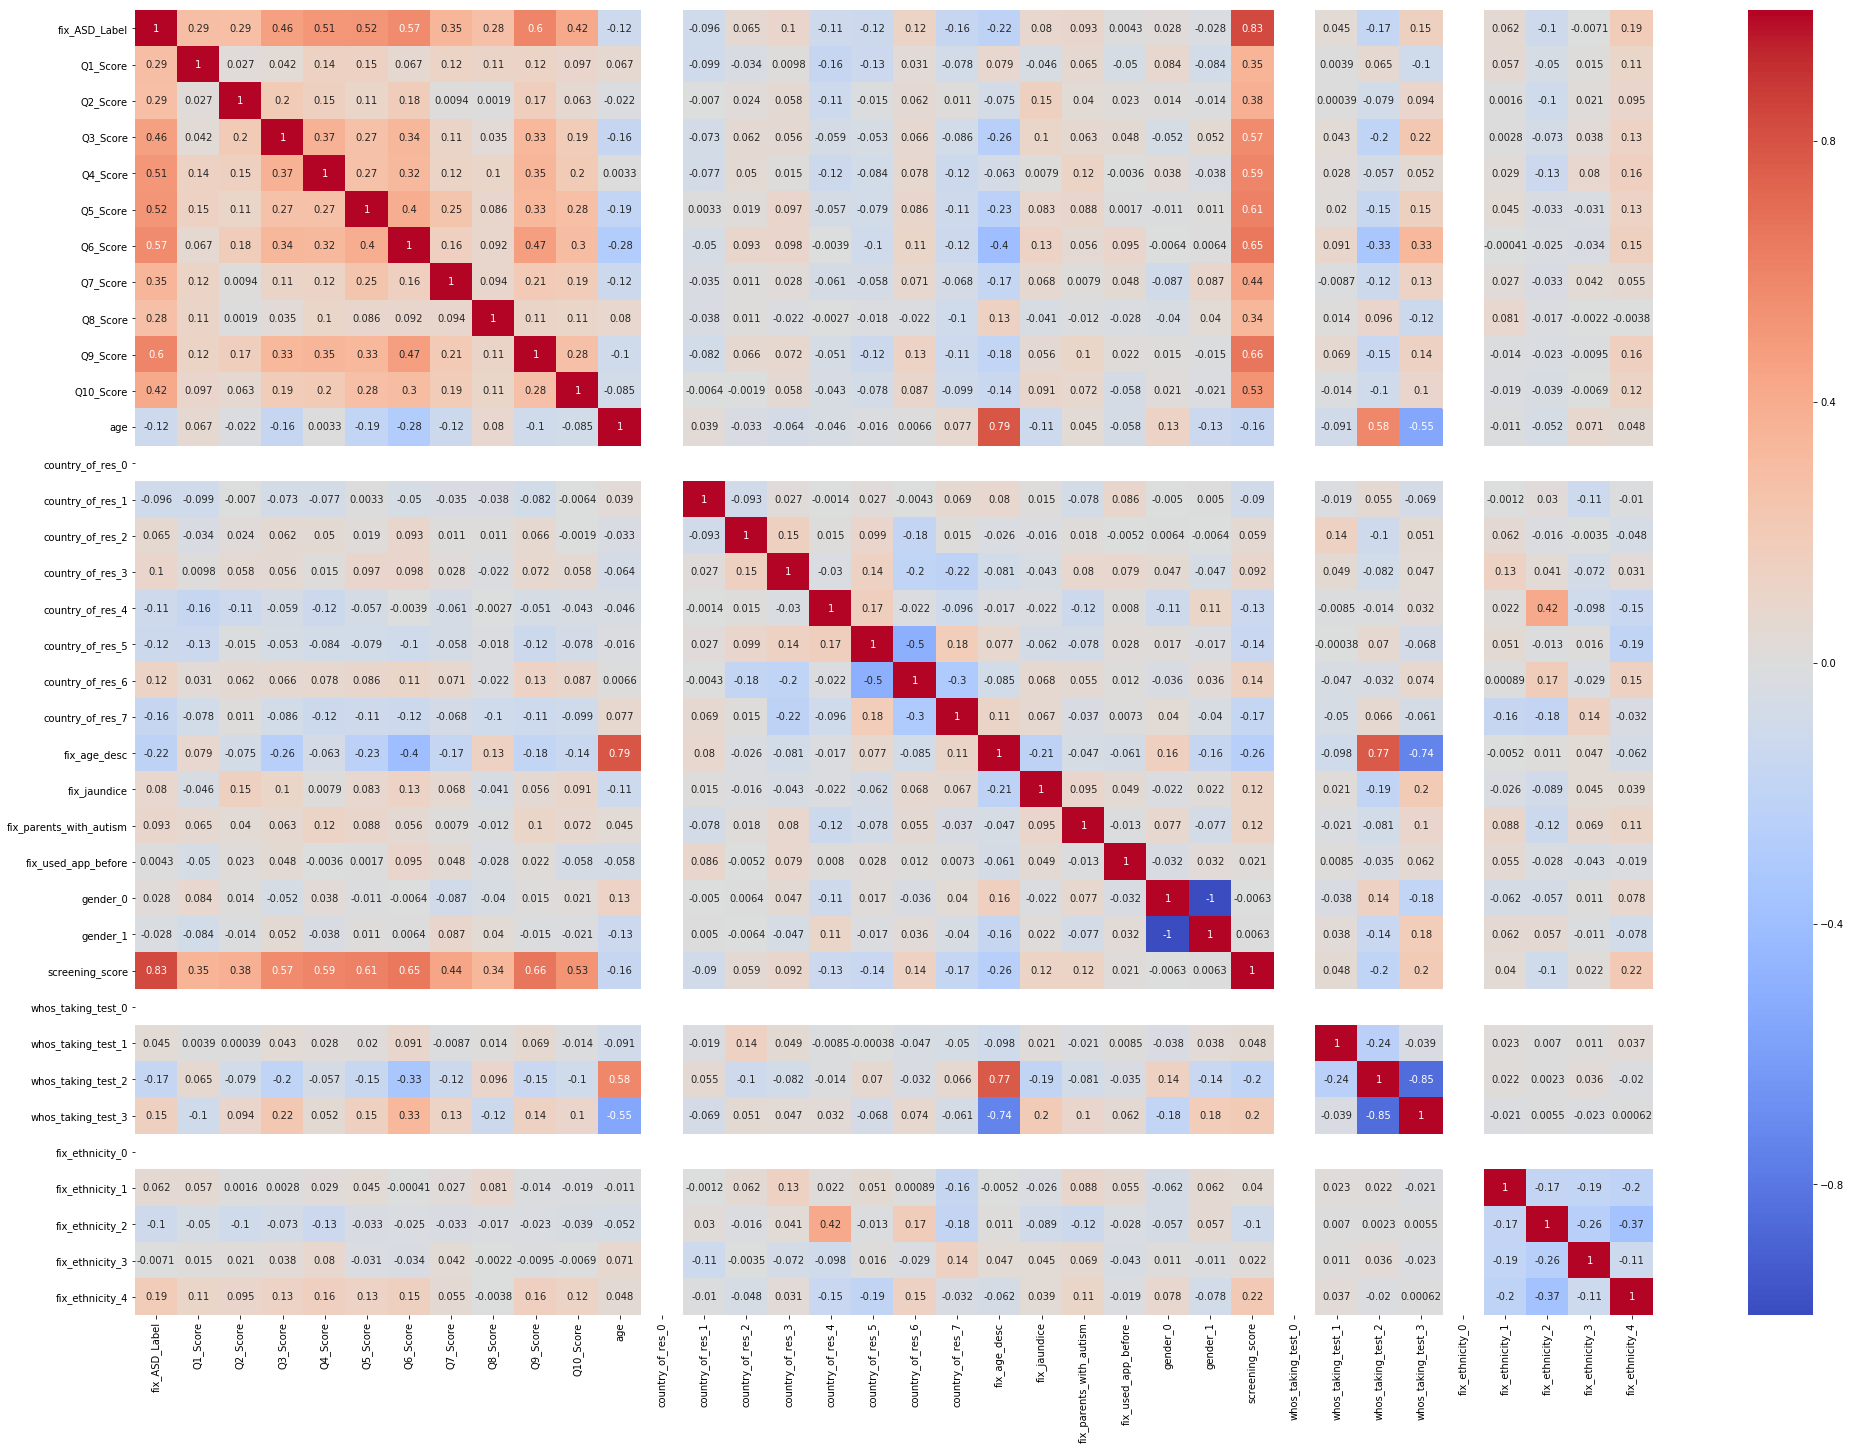

In [139]:
plt.figure(figsize=(34,24))
sns.heatmap(ASD_cleaned_df.corr(),cbar=True,cmap='coolwarm',annot=True)

##### As SCREENING_SCORE is highly co-related with FIX_ASD_LABEL.

In [140]:
ASD_cleaned_df.drop(['screening_score'],axis=1,inplace=True)

#### **Predicting the values for NULL values in AGE variable**

In [141]:
ASD_age_not_null = ASD_cleaned_df[~ASD_cleaned_df['age'].isna()]

In [142]:
ASD_age_not_null.shape

(1093, 35)

In [143]:
ASD_age_null = ASD_cleaned_df[ASD_cleaned_df['age'].isna()]

In [144]:
ASD_age_null.shape

(7, 35)

#### **Import the Algo to train and predict the MISSING values in AGE**

In [146]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [147]:
ASD_cleaned_df.head()

,fix_ASD_Label,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,age,country_of_res_0,country_of_res_1,country_of_res_2,country_of_res_3,country_of_res_4,country_of_res_5,country_of_res_6,country_of_res_7,fix_age_desc,fix_jaundice,fix_parents_with_autism,fix_used_app_before,gender_0,gender_1,whos_taking_test_0,whos_taking_test_1,whos_taking_test_2,whos_taking_test_3,fix_ethnicity_0,fix_ethnicity_1,fix_ethnicity_2,fix_ethnicity_3,fix_ethnicity_4
0,0,1,1,0,0,1,1,0,1,0,0,6.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1,0,1,1,0,0,1,1,0,1,0,0,6.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,1,1,1,1,1,1,1,1,1,1,1,5.0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1
3,1,1,0,1,1,1,1,0,1,0,1,5.0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1
4,1,1,1,1,1,1,1,1,1,0,0,5.0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [201]:
X_ASD_age_not_null = ASD_age_not_null[['fix_ASD_Label', 'Q1_Score', 'Q2_Score', 'Q3_Score', 'Q4_Score',
       'Q5_Score', 'Q6_Score', 'Q7_Score', 'Q8_Score', 'Q9_Score', 'Q10_Score',
       'country_of_res_0', 'country_of_res_1', 'country_of_res_2',
       'country_of_res_3', 'country_of_res_4', 'country_of_res_5',
       'country_of_res_6', 'country_of_res_7', 'fix_age_desc', 'fix_jaundice',
       'fix_parents_with_autism', 'fix_used_app_before', 'gender_0',
       'gender_1', 'whos_taking_test_0', 'whos_taking_test_1',
       'whos_taking_test_2', 'whos_taking_test_3', 'fix_ethnicity_0',
       'fix_ethnicity_1', 'fix_ethnicity_2', 'fix_ethnicity_3',
       'fix_ethnicity_4']]

In [202]:
Y_ASD_age_not_null = ASD_age_not_null['age']

#### **Splitting the train and test dataset**

In [203]:
X_train, X_test, y_train, y_test = tts(X_ASD_age_not_null,Y_ASD_age_not_null,test_size=0.25,random_state=44)

#### **Shape of training and testing datasets**

In [204]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((819, 34), (819,), (274, 34), (274,))

#### **Instantiating the Regression model**

In [223]:
rf_reg = RandomForestRegressor(n_estimators=100,max_depth=8)

#### **Fitting the model**

In [224]:
model_rf = rf_reg.fit(X_train,y_train)

#### **Predicting the values on testing dataset**

In [225]:
y_predict = model_rf.predict(X_test)

#### **Predicting the values on unseen dataset**

In [226]:
model_rf.predict(ASD_age_null[['fix_ASD_Label', 'Q1_Score', 'Q2_Score', 'Q3_Score', 'Q4_Score',
       'Q5_Score', 'Q6_Score', 'Q7_Score', 'Q8_Score', 'Q9_Score', 'Q10_Score',
       'country_of_res_0', 'country_of_res_1', 'country_of_res_2',
       'country_of_res_3', 'country_of_res_4', 'country_of_res_5',
       'country_of_res_6', 'country_of_res_7', 'fix_age_desc', 'fix_jaundice',
       'fix_parents_with_autism', 'fix_used_app_before', 'gender_0',
       'gender_1', 'whos_taking_test_0', 'whos_taking_test_1',
       'whos_taking_test_2', 'whos_taking_test_3', 'fix_ethnicity_0',
       'fix_ethnicity_1', 'fix_ethnicity_2', 'fix_ethnicity_3',
       'fix_ethnicity_4']])

array([ 6.28733269, 28.70235946,  8.23749743,  6.8093296 ,  4.86639387,
       28.8954651 , 25.42701618])

In [ ]:
np.array(y_test).reshape(1,-1)

In [ ]:
print(y_predict)

In [227]:
MAE(y_test,np.floor(y_predict))

4.857664233576642

In [228]:
np.sqrt(MSE(y_test,np.floor(y_predict)))

7.222986421606739

#### **Support Vector Regressor**

In [229]:
from sklearn.svm import SVR

In [232]:
svr = SVR(gamma='scale')

In [233]:
model_svr = svr.fit(X_train,y_train)

In [235]:
y_predict_svr = svr.predict(X_test)

In [237]:
np.sqrt(MSE(y_test,y_predict_svr))

8.20929799749158

#### **Gradient Boosting Regressor**

In [238]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [258]:
gbr = GBR(loss='lad',n_estimators=200)

In [259]:
model_gbr = gbr.fit(X_train,y_train)

In [260]:
y_predict_gbr = model_gbr.predict(X_test)

In [261]:
np.sqrt(MSE(y_test,y_predict_gbr))

7.454358468486904

#### **XGBoost Regressor**

In [263]:
!pip install xgboost

    100% |████████████████████████████████| 109.8MB 451kB/s eta 0:00:01
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [330]:
from xgboost import XGBRFRegressor as XGR

In [331]:
xgr = XGR(learning_rate=1)

In [332]:
model_xgr = xgr.fit(X_train,y_train)

In [333]:
y_predict_xgr = xgr.predict(X_test)

In [334]:
np.sqrt(np.floor(MSE(y_test,y_predict_xgr)))

7.3484692283495345

In [291]:
age_prediction = model_xgr.predict(ASD_age_null[['fix_ASD_Label', 'Q1_Score', 'Q2_Score', 'Q3_Score', 'Q4_Score',
       'Q5_Score', 'Q6_Score', 'Q7_Score', 'Q8_Score', 'Q9_Score', 'Q10_Score',
       'country_of_res_0', 'country_of_res_1', 'country_of_res_2',
       'country_of_res_3', 'country_of_res_4', 'country_of_res_5',
       'country_of_res_6', 'country_of_res_7', 'fix_age_desc', 'fix_jaundice',
       'fix_parents_with_autism', 'fix_used_app_before', 'gender_0',
       'gender_1', 'whos_taking_test_0', 'whos_taking_test_1',
       'whos_taking_test_2', 'whos_taking_test_3', 'fix_ethnicity_0',
       'fix_ethnicity_1', 'fix_ethnicity_2', 'fix_ethnicity_3',
       'fix_ethnicity_4']])

In [292]:
age_prediction = np.floor(age_prediction)

In [293]:
age_prediction

array([ 6., 28.,  7.,  6.,  4., 28., 26.], dtype=float32)

#### **Replacing the Missing values AGE column by the predicted result**

In [296]:
ASD_age_null

,fix_ASD_Label,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,age,country_of_res_0,country_of_res_1,country_of_res_2,country_of_res_3,country_of_res_4,country_of_res_5,country_of_res_6,country_of_res_7,fix_age_desc,fix_jaundice,fix_parents_with_autism,fix_used_app_before,gender_0,gender_1,whos_taking_test_0,whos_taking_test_1,whos_taking_test_2,whos_taking_test_3,fix_ethnicity_0,fix_ethnicity_1,fix_ethnicity_2,fix_ethnicity_3,fix_ethnicity_4
47,0,0,0,1,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
391,0,1,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,1,1,0,1,3,0,0,0,1,0,0,0,1,0,0,0,1,1,1
965,1,1,0,0,1,0,1,1,1,1,1,NaN,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
977,1,1,1,1,1,0,1,0,1,0,1,NaN,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0
978,0,0,1,1,0,1,1,1,1,0,0,NaN,0,1,0,1,0,1,0,1,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1
1013,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,0,0,0,1,1,3,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1017,0,0,1,0,0,1,0,1,0,0,1,NaN,0,0,0,0,0,0,0,1,3,0,0,0,1,0,0,0,1,0,0,0,0,1,0


In [301]:
ASD_age_null.shape

(7, 35)

In [308]:
ASD_age_null['age'] = age_prediction

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [309]:
ASD_age_null

,fix_ASD_Label,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,age,country_of_res_0,country_of_res_1,country_of_res_2,country_of_res_3,country_of_res_4,country_of_res_5,country_of_res_6,country_of_res_7,fix_age_desc,fix_jaundice,fix_parents_with_autism,fix_used_app_before,gender_0,gender_1,whos_taking_test_0,whos_taking_test_1,whos_taking_test_2,whos_taking_test_3,fix_ethnicity_0,fix_ethnicity_1,fix_ethnicity_2,fix_ethnicity_3,fix_ethnicity_4
47,0,0,0,1,0,0,0,0,0,0,0,6.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
391,0,1,0,0,0,0,0,0,0,0,0,28.0,0,0,0,0,1,1,0,1,3,0,0,0,1,0,0,0,1,0,0,0,1,1,1
965,1,1,0,0,1,0,1,1,1,1,1,7.0,0,0,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
977,1,1,1,1,1,0,1,0,1,0,1,6.0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0
978,0,0,1,1,0,1,1,1,1,0,0,4.0,0,1,0,1,0,1,0,1,1,1,0,1,0,1,0,0,0,1,0,0,0,0,1
1013,0,0,0,0,0,0,0,0,0,0,0,28.0,0,0,1,0,0,0,1,1,3,0,0,0,0,1,0,0,1,0,0,0,0,1,0
1017,0,0,1,0,0,1,0,1,0,0,1,26.0,0,0,0,0,0,0,0,1,3,0,0,0,1,0,0,0,1,0,0,0,0,1,0


In [300]:
ASD_age_not_null.shape

(1093, 35)

In [304]:
ASD_pre_processed = pd.concat([ASD_age_not_null,ASD_age_null],axis=0)

In [305]:
ASD_pre_processed.head()

,fix_ASD_Label,Q1_Score,Q2_Score,Q3_Score,Q4_Score,Q5_Score,Q6_Score,Q7_Score,Q8_Score,Q9_Score,Q10_Score,age,country_of_res_0,country_of_res_1,country_of_res_2,country_of_res_3,country_of_res_4,country_of_res_5,country_of_res_6,country_of_res_7,fix_age_desc,fix_jaundice,fix_parents_with_autism,fix_used_app_before,gender_0,gender_1,whos_taking_test_0,whos_taking_test_1,whos_taking_test_2,whos_taking_test_3,fix_ethnicity_0,fix_ethnicity_1,fix_ethnicity_2,fix_ethnicity_3,fix_ethnicity_4
0,0,1,1,0,0,1,1,0,1,0,0,6.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
1,0,1,1,0,0,1,1,0,1,0,0,6.0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,1,1,1,1,1,1,1,1,1,1,1,5.0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1
3,1,1,0,1,1,1,1,0,1,0,1,5.0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1
4,1,1,1,1,1,1,1,1,1,0,0,5.0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0


#### **Evaluating Classifier Models**

In [341]:
X_train1, X_test1, y_train1, y_test1 = tts(ASD_pre_processed.iloc[:,1:],ASD_pre_processed.iloc[:,0],test_size=0.25,random_state=11)

In [353]:
from sklearn.metrics import accuracy_score as acr_scr
from sklearn.metrics import recall_score as rec_scr
from sklearn.metrics import precision_score as prec_scr
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [338]:
from xgboost import XGBClassifier as XGBC

In [339]:
xgbc = XGBC()

In [343]:
model_xgbc = xgbc.fit(X_train1,y_train1)

In [344]:
y_predict_xgbc = model_xgbc.predict(X_test1)

In [347]:
prec_scr(y_test1,y_predict_xgbc)

0.9736842105263158

In [346]:
rec_scr(y_test1,y_predict_xgbc)

0.9487179487179487

#### **K-fold validation**

In [352]:
np.mean(cross_val_score(model_xgbc,ASD_pre_processed.iloc[:,1:],ASD_pre_processed.iloc[:,0],cv=10,n_jobs=4))

0.9645515406983296

#### **Confusion Matrix**

In [354]:
confusion_matrix(y_test1,y_predict_xgbc)

array([[155,   3],
       [  6, 111]])